In [81]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import ellipk, ellipe
%matplotlib inline

from mpl_settings_v3 import *

data_dir = '../../data'

### **Valores teóricos**

In [88]:
## Temperatura crítica
Tc_theo = 2/np.log(1+np.sqrt(2))

## Magnetización
def m_theo(t_values, J=1):
    n = len(t_values)
    m_values = np.zeros(n)
    for i, t in enumerate(t_values):
        if t < Tc_theo:
            m_values[i] = (1 - np.sinh(2*J/t)**(-4))**(1/8)
    return m_values

## Susceptibilidad
def e_theo(t_values, J=1):
    kappa_prima = 2*np.tanh(2*J/t_values)**2 - 1
    kappa_squared = 1-kappa_prima**2
    return -J/np.tanh(2*J/t_values) * (1 + 2/np.pi * kappa_prima*ellipk(kappa_squared))
## Calor específico

def Cp_theo(t_values, J=1):
    kappa_prima = 2*np.tanh(2*J/t_values)**2 - 1
    kappa_squared = 1 - kappa_prima**2
    return 2/np.pi * (J/(t_values*np.tanh(2*J/t_values)))**2 * \
          (2*ellipk(kappa_squared) - 2*ellipe(kappa_squared) - \
           (1-kappa_prima) * (np.pi/2 + kappa_prima*ellipk(kappa_squared)))

In [199]:
transit = 10000
decorr = 10000
n_samples = 10000
Ti = 1.00
Tf = 4.00
delta_T = 0.01
theo_t_values = np.linspace(1, Tf, 10000)
L_values = [16, 32]#, 64, 128]#, 200]
columns = ['t', 'e', 'm', 'Cp', 'chi', 'm2', 'm4']
dfs = {}
for L in L_values:
    input_file_name = "L{}_Ti{:.2f}_Tf{:.2f}_dT{}_transit{}_Ns{}_nsamples{}.dat".format(L, Ti, Tf, delta_T, transit,
                                                                                 decorr, n_samples)
    full_input_file_name = os.path.join(data_dir, input_file_name)
    data = np.loadtxt(full_input_file_name)
    df = pd.DataFrame(data, columns=columns)
    #df = df.set_index('T')
    dfs[L] = df
    

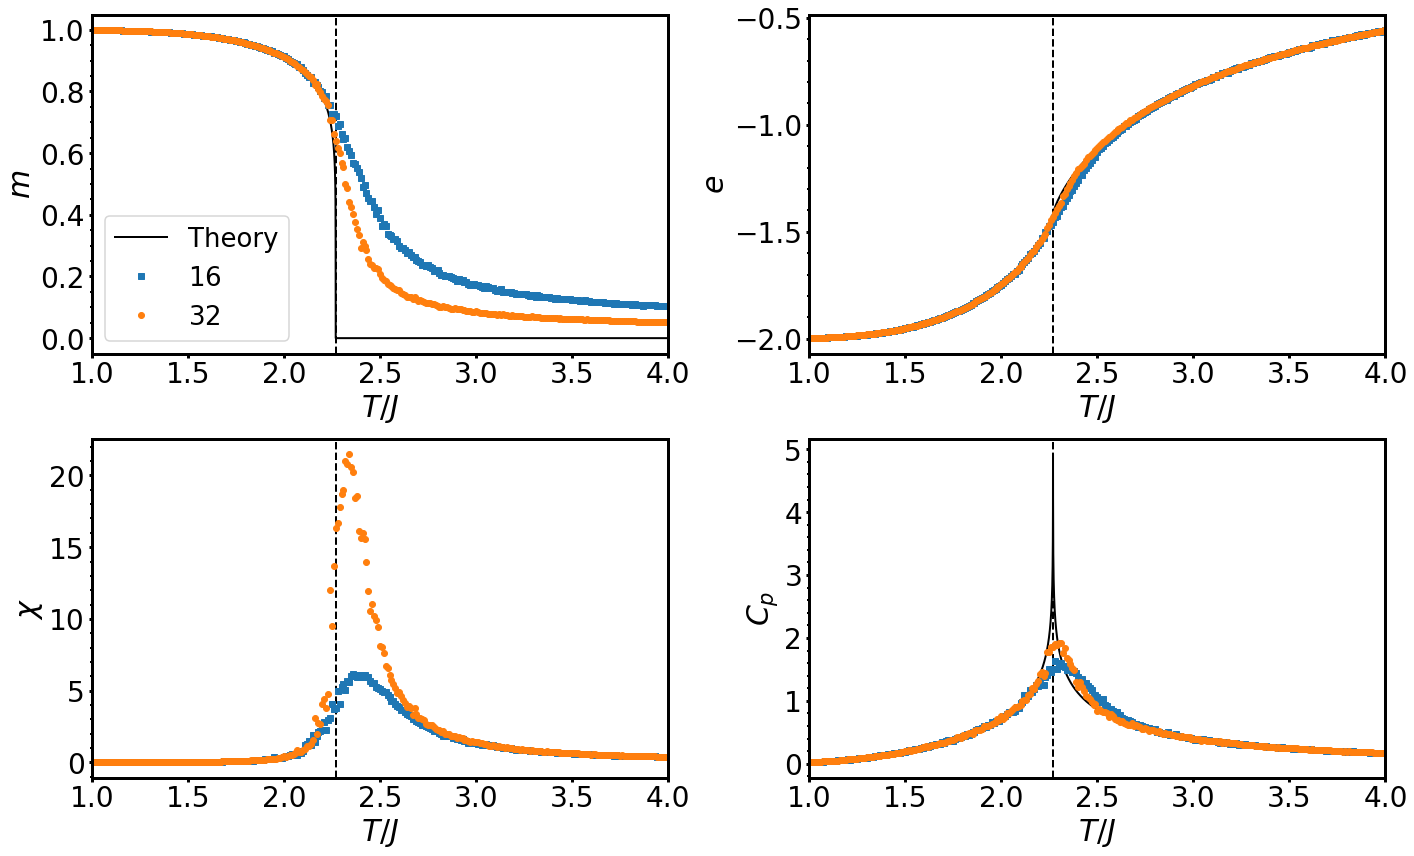

In [200]:
ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols,6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlabel(r'$T/J$')
    ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
    ax.set_xlim(1, 4)
## Magnetizacion
ax = axes[0][0]
ax.set_ylabel(r'$m$')
ax.plot(theo_t_values, m_theo(theo_t_values), color='k', linewidth=2, label=r'Theory')
for i, L in enumerate(L_values):
    df = dfs[L] 
    ax.plot(df.t, df.m, markers[i], label=r'${{{}}}$'.format(L))
ax.legend(loc='lower left')


## Energia
ax = axes[0][1]
ax.set_ylabel(r'$e$')
ax.plot(theo_t_values, e_theo(theo_t_values), color='k', linewidth=2)
for i, L in enumerate(L_values):
    df = dfs[L]
    ax.plot(df.t, df.e, markers[i])

# Susceptibilidad
ax = axes[1][0]
ax.set_ylabel(r'$\chi$')
for i, L in enumerate(L_values):
    df = dfs[L]
    ax.plot(df.t, df.chi, markers[i])

    
## Calor especifico
ax = axes[1][1]
ax.set_ylabel(r'$C_p$')

ax.plot(theo_t_values, Cp_theo(theo_t_values), color='k', linewidth=2)

for i, L in enumerate(L_values):
    df = dfs[L]
    ax.plot(df.t, df.Cp,  markers[i])
    
plt.tight_layout()
plt.show()

### **Determinación de $T_c$ utilizando cumulantes de Binder**

El cumulante de Binder se define como la curtosis de la distribución de probabilidad de $M$. Es decir,

$$
U = 1 - \dfrac{\langle M \rangle^4}{3\langle M^2 \rangle^2}
$$

A temperatura cero, $U = 2/3$, mientras que a temperatura infinita, $U\rightarrow 0$.

Cerca del punto crítico, el cumulante tiene un comportamiento del tipo 

$$
U(T,L) = b(tL^{1/\nu}),
$$

donde $t = (T-T_c)/T_c$ es la temperatura reducida. Por lo tanto, las curvas de $U(T, L)$ para distintos valores de $L$ deben cruzarse en $T=T_c$.

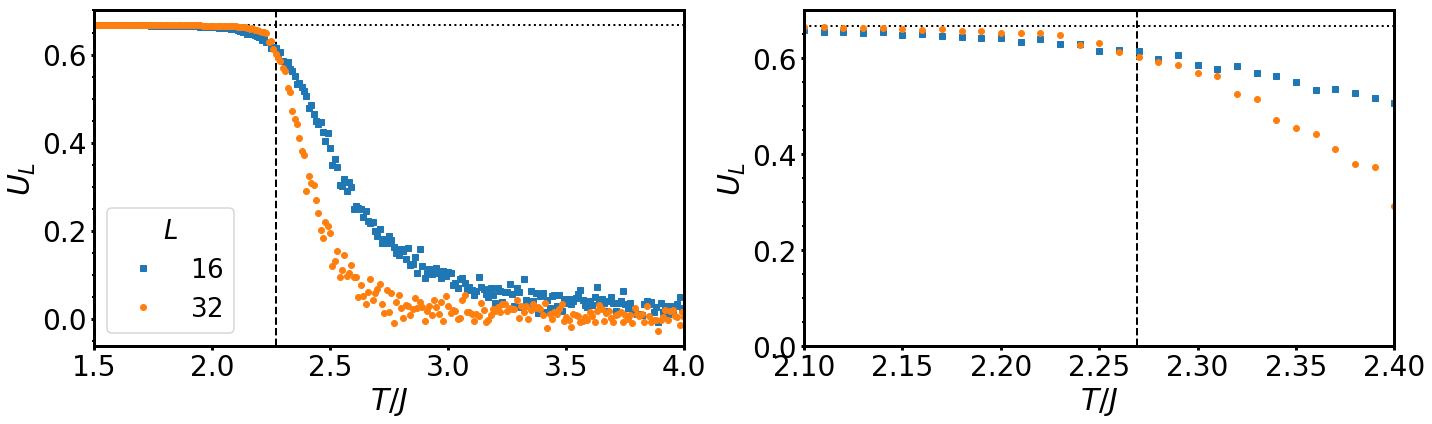

In [209]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlabel(r'$T/J$')
ax.set_xlim(1.5, 4)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
ax.axhline(2/3, color='k', linestyle=':', linewidth=2)
    
## Binder
ax.set_ylabel(r'$U_L$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    binder = 1 - df.m4 / (3*df.m2**2)
    ax.plot(df.t, binder, markers[i], label=r'${{{}}}$'.format(L))
legend = ax.legend(loc='lower left')
legend.set_title(r'$L$', prop={'size': 26})


ax = axes[1]
ax.set_xlabel(r'$T/J$')
ax.set_ylim(0, 0.7)
ax.set_xlim(2.1, 2.4)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
ax.axhline(2/3, color='k', linestyle=':', linewidth=2)
    
## Binder
ax.set_ylabel(r'$U_L$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    binder = 1 - df.m4 / (3*df.m2**2)
    ax.plot(df.t, binder, markers[i])
    
plt.tight_layout()
plt.show()

### **Comportamiento de la magnetización para $T>T_c$ y tamaños finitos**

En sistemas de tamaño finito, la magnetización no se anula en la fase paramagnética, sino que decae como $\sqrt{N}$. Luego, si graficamos $\sqrt{N}\;m(T, L)$ en función de $T$ para $T > T_c$, las curvas para diferentes tamaños deberían colapsar.

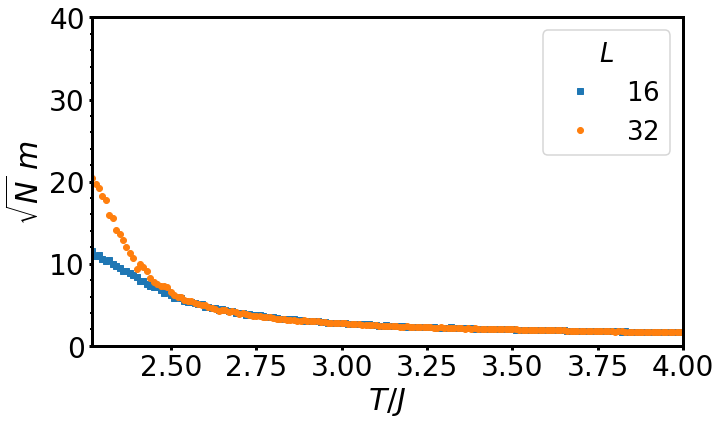

In [210]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax.set_xlabel(r'$T/J$')
ax.set_ylim(0, 40)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
    
## Magnetizacion
ax.set_xlim(Tc_theo, Tf)
ax.set_ylabel(r'$\sqrt{N}\;m$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    ax.plot(df.t, df.m*L, markers[i], label=r'${{{}}}$'.format(L))
legend = ax.legend(loc='best')
legend.set_title(r'$L$', prop={'size': 26})
    
plt.tight_layout()
plt.show()